# Analysis of Gnosis Constant Product and Logrithmic Market Maker In One Sided Markets
## What's the worst that can happen?


by Michael Watson <a href="https://twitter.com/detroitcoder" target="_blank">@detroitcoder</a> and founder at <a href="https://chainedmetrics.com" target="_blank">chainedmetrics.com</a>

Market Making in prediction markets is a very tricky problem to solve. Most markets have low liquidity, asymetric information, and driven by events where a lot of flow can come all at once. Inherently not ideal conditions for any market making activity. Automated Market makers have brought a tremendous amount of initial growth in the DEFI space, and they do have applications to prediction markets. However per the issues mentioned, AMMs can be peticularly vulnerable to adverse market conditions, especially on prediction markets where outcomes are binary. So to start I want to ask the question, "well what's the worst that can happen?" To start I implemented both the LMSR and the CPMM described in <a href="https://docs.gnosis.io/conditionaltokens/docs/introduction3/" target="_blank">the gnosis documentation</a> and simulated trading in each one. These are the contracts and implementations that are copied for Polymarket for example. 

The goal was to understand how the market makers responded to one sided market condidtions and calc the minimum amount of volume needed to break even using the fee revenue. Each market starts trading at .5/.5 and then I simulate trading to move the market in increments of .05 with both  AMM types and various fee levels. Then I continue simulating trades to see what amount of volume is necessary to remain profitable. You can see that with the LMSR, I am protected of losing more than 75% of my LP funding no matter how adversarial the conditions are (not sure if that's good but surprised it was not 100%). Also starting at 5% fees, the CPMM can remain profitibale with a width of +-1500 bps in price. Obviously this is not ideal for a market making strategy, but having a better understanding of these maket dynamics is an important step in the evolution of the space. Althought we are only dealing with binary outcomes, I did generalzie the functions so that the outcome_inventory attribute could hold an arbitrary number of outcomes.

As a preface this is just what I put together this afternoon with no-one reviewing so expect a high likelihood that there is a bug and it is all invalid :)

In [8]:
import math

class LMSR():
    '''
    Logarithmic Market Scoring Rules described in the Gnosis docs
    
    invariant = sum(numOutcomes^(-numOutcomeTokensInInventoryForOutcome / funding) for every outcome)
    '''
    
    def __init__(self, fund, fee=0):
        '''
        Sets the initial funding and fee structure
        
        Args:
            fund (int): The total initial funding amount
            fee (float): The fee to charge per trade
        '''
        
        # The inventory stored the marketmaker. 0 & 1 are meant to represent the binary outcomes
        self.outcome_inventory = {
            0: fund,
            1: fund
        }

        self.funding = fund
        self.target_invariant = self.calc_invariant()
        self.fee = fee
        self.fee_account = 0
        self.volume = 0
    
    def calc_invariant(self):
        '''
        Calcs the initial invariant that remains fixed for the life of the marketmaker. This
        example assumes that the initial targe price is .5/.5
        '''
        
        invariant = 0
        for outcome, inventory in self.outcome_inventory.items():
            add_invariant = len(self.outcome_inventory) ** (-self.outcome_inventory[outcome] / self.funding)
            invariant += add_invariant
            
        return invariant
    
    def buy_token(self, outcome, amount):
        '''
        Simulates the the purchase of the outcome tokens for the corresponding amount. This
        method will take a fee first of the amount, then collatoralize the remainder by
        purchasing both outcomes, and lastly determine the quantity to necessary to return
        in order to meet the invariant condition
        
        Args:
            outcome (0 or 1): The binary outcome being purchased
            amount (float): The $ amount requested to purchase
            
        Returns:
            purchased_quantity (float): The quantity of the outcome token purchased
        '''

        fee_revenue = amount * self.fee
        self.fee_account += fee_revenue
        amount = amount - fee_revenue
        self.volume += amount
        
        for _o in self.outcome_inventory:
            self.outcome_inventory[_o] += amount
            
        balancing_quantity = self.calc_target_invariant(outcome)
        purchased_quantity = self.outcome_inventory[outcome] - balancing_quantity
        self.outcome_inventory[outcome] -= purchased_quantity
        
        return purchased_quantity        
        
    def calc_target_invariant(self, outcome):
        '''
        Calculates that amount of the outcome tokens that need to be returned for the purchase
        in order to keep the invariant formula intact
        
        Args:
            outcome (0 or 1): The outcome being requested to purchase
        
        Returns:
            float: The quantity of the outcome token that will keep the invariant satisfied
        '''
        
        inventory_sum = 0
        for _o, amount in self.outcome_inventory.items():
            if _o != outcome:
                inventory_sum += len(self.outcome_inventory) ** (-1 * self.outcome_inventory[_o] / self.funding)

        return (-1 * self.funding) * math.log(self.target_invariant - inventory_sum, len(self.outcome_inventory))
    
    def max_loss(self):
        '''
        Determines the max percentage of funds that the MM could lose if they withdrew their funds, took their fees, 
        and waited for the the outcome to resolve, and assume the higher priced outcome is the the winning scenario. 
        
        This assumption is the worse case outcome for the market maker, if the cheaper outcome occurs they make
        every time
        '''
        
        return (self.fee_account - (self.funding - min(self.outcome_inventory.values()) )) / self.funding
    
    def outcome_odds(self, outcome):
        '''
        Calculates the outcome odds for the given outcome given the current inventory. This is taken directly from
        the Gnosis section on implied odds section.
        
        From Gnosis Docs:
        oddsForOutcome = numOutcomes^(-numOutcomeTokensInInventoryForOutcome / funding)
        '''
        
        return 2 ** (-1 * self.outcome_inventory[outcome] / self.funding)
        

In [2]:
class CPMM():
    '''
    Constant Product Market Maker described in the Gnosis docs. 
    
    These methods are the exact same as the LSRM but for the Constant Product Implementation.
    For details refer to the LSRM doc strings AND read the Gnosis docs
    
    invariant = product(numOutcomeTokensInInventoryForOutcome for every outcome)
    '''
    
    def __init__(self, fund, fee=0):
        self.outcome_inventory = {
            0: fund,
            1: fund
        }

        self.funding = fund
        self.target_invariant = self.calc_invariant()
        self.fee = fee
        self.fee_account = 0
        self.volume = 0
    
    def calc_invariant(self):
        invariant = 1
        
        for v in self.outcome_inventory.values():
            invariant = invariant * v        
            
        return invariant
    
    def buy_token(self, outcome, amount):
        
        fee_revenue = amount * self.fee
        self.fee_account += fee_revenue
        amount = amount - fee_revenue
        self.volume += amount
        
        for _o in self.outcome_inventory:
            self.outcome_inventory[_o] += amount
            
        balancing_quantity = self.calc_target_invariant(outcome)
        purchased_quantity = self.outcome_inventory[outcome] - balancing_quantity
        self.outcome_inventory[outcome] -= purchased_quantity
        
        return purchased_quantity        
        
    def calc_target_invariant(self, outcome):
        
        current_invariant = 1
        for _o, amount in self.outcome_inventory.items():
            if _o != outcome:
                current_invariant = current_invariant * amount

        return self.target_invariant / current_invariant
    
    def max_loss(self):
        
        return (self.fee_account - (self.funding - min(self.outcome_inventory.values()) )) / self.funding
    
    def outcome_odds(self, outcome):
        '''
        oddsWeightForOutcome = product(numOutcomeTokensInInventoryForOtherOutcome for every otherOutcome)
        oddsForOutcome = oddsWeightForOutcome / sum(oddsWeightForOutcome for every outcome)
        '''
        
        oddsWeightForOutcome = math.prod(v for k, v in self.outcome_inventory.items() if k != outcome)
        
        denominator = 0
        for _o in self.outcome_inventory:
            denominator += math.prod(v for k, v in self.outcome_inventory.items() if _o != k)
        
        return oddsWeightForOutcome / denominator

With the above defined the first item that I wanted to explore was how the pricing responded to single sided trades. The below iterates over prices of both the LMSR and CPMM, each with 100 in funding and a 2% fee structure. Each dot represnts a trade and the cumulative volume on x axis. The top chart is the price paid for the tokens net of fees and the bottom chart is the ROI of the market maker if they withdrew funds immediately. Blue is LMSR and Orange is CPMM.

Populating the interactive namespace from numpy and matplotlib


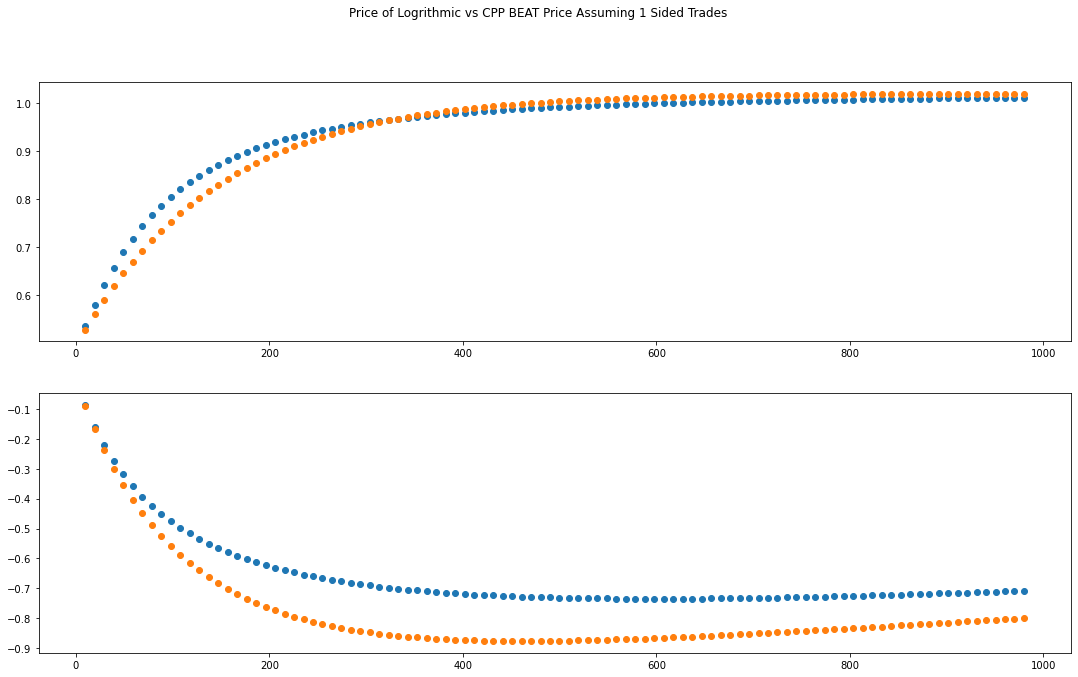

In [3]:
%pylab inline
import numpy as np
from matplotlib import pyplot as plt

# instantiate the logrithmic and constant product market makers
c_market = CPMM(100, .02)
l_market = LMSR(100, .02)

c_prices = []
l_prices = []
c_loss = []
l_loss = []

for i in range(100):
    c_quantity = c_market.buy_token(1, 10)
    l_quantity = l_market.buy_token(1, 10)  
    
    c_prices.append([c_market.volume, 10 / c_quantity])
    l_prices.append([l_market.volume, 10 / l_quantity])
    
    c_loss.append([c_market.volume, c_market.max_loss()])
    l_loss.append([l_market.volume, l_market.max_loss()])


fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Price of Logrithmic vs CPP BEAT Price Assuming 1 Sided Trades and 2% Fees')
fig.set_size_inches(18.5, 10.5, forward=True)
cx, cy = np.array(c_prices).T
lx, ly = np.array(l_prices).T
ax1.scatter(cx,cy)
ax1.scatter(lx,ly)

ax2.scatter(*np.array(c_loss).T)
ax2.scatter(*np.array(l_loss).T)
plt.show()

As you can see that the LSRM is more responsive to the initial one sided trades with a steeper slope, which corresponds to the flater sloap in the negative ROI. This defensive structure is definitely preferable in a one sided trade. Although it is still decimating the funding, the LMRS has **only** lost 60% of funds when volume is 2x their initial funding (200 on x axis) and all of it is trading for a Yes outcome. Better yet it never falls below 75% of total funding loss compared to the CPMM which loses close to 90% of funds. HOWEVER, the goal of a market maker is not take this kind of exposure ever and it is clear both naive implementations are easy prey to large one sided trades (or many small ones all unidirectional). The convexity in the second chart is the fee revenue starting kicking in as both prices converge to 1, however this is unlikely to ever happen given the expected payout of the buyer is less than the puchase price net of fees.

So next let's determine what amount of volume and fee is needed at various deviations from the 50/50 starting price to break even. The below function simulates trades where the target odds (eg 60/40) are represented by trades that are weighted 60/40. Eventually the market converges on this price.

In [4]:
def calc_max_break_even(funding, fee, target_odds, market_class):
    '''
    Calculate the volume as a percent of funding needed to break even given assuming the starting
    odds are 50/50.
    
    Arguments:
        funding (int): The amount of $ funding the LP provides to the market
        fee (float): The Fee in decimals that are paid to market maker
        target_odds (float): The target odds that we want to similuate the market converging to
        market_class (CPMM or LMSR): The automated market maker class to use
        
    Returns:
        float: The volume as a percent of funding amount required to break even
        
    Notes:
        This function uses a trick of submitting Yes/No orders with a quantity the equal to
        the target odds & 1-target odds. This causes the prices to converge on the odds that we are
        targeting. However I think it might be more efficient with the CPMM than the LMSR
    '''
    market = market_class(funding, fee)
    
    '''
    # This was a second implementation where I get the odds as quickly as possible to the 
    #  target odds, and then keep trades inline with the target ratio until the volume offsets
    #  the market maker losses. This however did not make any tangible difference. It
    #  does have the largest impact on the LRSM which gets % of volume for a 5% to below 2x funding
    
    while market.outcome_odds(1) < target_odds:
        market.buy_token(1, target_odds)
    '''
        
    while True:
        market.buy_token(1, target_odds)
        market.buy_token(0, (1-target_odds))
        if market.max_loss() > 0:
            return market.volume / funding

Now let's iterate over different fee structures and the market makers and take a look at how much volume is really needed to break even as an LP! Each of these assumes 10K in LP funding and is plotted below. The first chart in the top left represents a CPMM with 1% in fees going to the market maker. It looks like if the price moves on us just 10% from .5 to .6, we need to get at least 20x our funding, or 200K in volume to make up our exposure to the price move. It looks like the LMSR does even worse at 25X! This is not good, as a 10% move in price is very common in these markets. 

Let's scroll down and take a look further down. Looks like once we get to fees around 5% we can see a couple scenarios that are more palatable. CPMM will need 5x volume from funding to break even at .65. This means an LP can have a total width of .3 (+- 30%) and be able to make a market profitibly if they can attract 5x the volume. Now that is easier said than done and users will not be excited about the increase to fees, but that seems maybe doable. However I highly expect there will need to be a lot more incentives in place in order to attract enough liquidity (cough cough, wink wink token drop). With that said, this is not the space for anyone to blindly provide liquidity here and I am really excited about the evolution of the space :).

In [5]:
fee_lst = (.01, .02, .03, .04, .05, .1, .15, .2)
results = {}
for name, model in (('Constant Product', CPMM), ('Logrithmic', LMSR)):
    results[name] = {}
    for fee in fee_lst:
        results[name][fee] = []
        for i in range(1, 10):
            odds = .5 + .05 * i
            volume = calc_max_break_even(10000, fee, odds, model)
            results[name][fee].append([odds, volume])
            

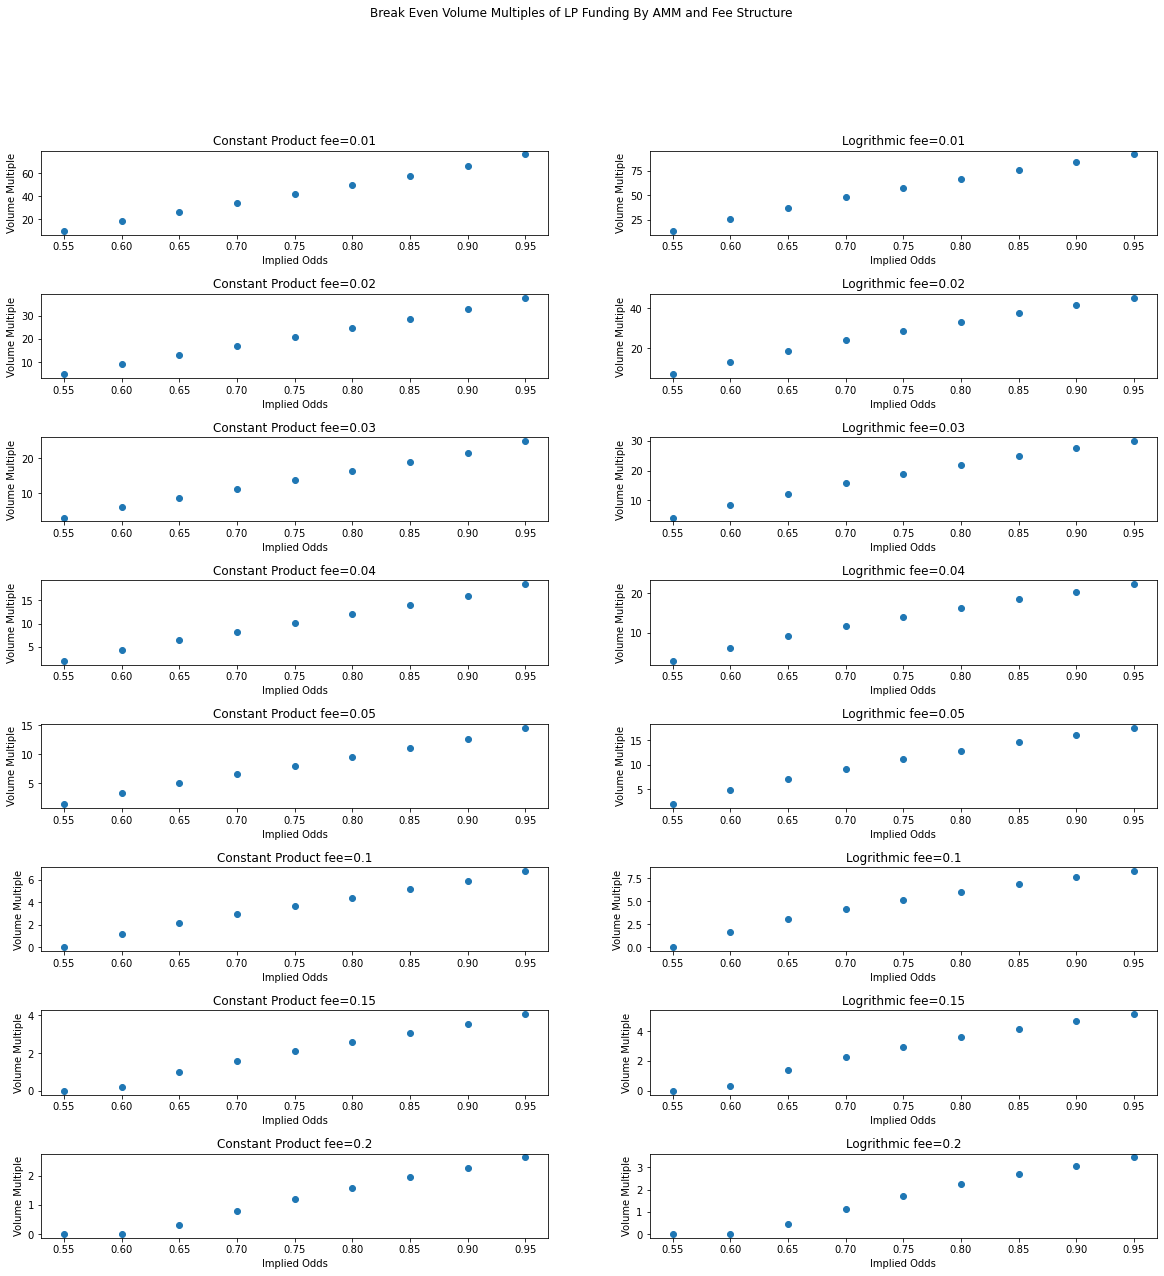

In [6]:
fig, axis = plt.subplots(len(fee_lst), 2, figsize=(20,20))
fig.suptitle('Break Even Volume Multiples of LP Funding By AMM and Fee Structure')

for i_amm, amm in enumerate(results.keys()):
    for i_fee, fee in enumerate(fee_lst):
        axe = axis[i_fee][i_amm]
        axe.set_title(f'{amm} fee={fee:.2}')
        axe.scatter(*np.array(results[amm][fee]).T)
        axe.set(xlabel='Implied Odds', ylabel="Volume Multiple")
        
plt.subplots_adjust(hspace=.7)
plt.show()

In [7]:
fee_lst = (.01, .02, .03, .04, .05, .1, .15, .2)
for name, model in (('Constant Product', CPMM), ('Logrithmic', LMSR)):
    results[name] = {}
    for fee in fee_lst:
        results[name][fee] = {}
        for i in range(1, 10):
            odds = .5 + .05 * i
            volume = calc_max_break_even(10000, fee, odds, model)
            print(f'{name} (fee={fee:.2f} odds={odds:.2f}) -  Break Even Volume: {volume:.4f}')

Constant Product (fee=0.01 odds=0.55) -  Break Even Volume: 9.4483
Constant Product (fee=0.01 odds=0.60) -  Break Even Volume: 18.1649
Constant Product (fee=0.01 odds=0.65) -  Break Even Volume: 26.3522
Constant Product (fee=0.01 odds=0.70) -  Break Even Volume: 34.1879
Constant Product (fee=0.01 odds=0.75) -  Break Even Volume: 41.8412
Constant Product (fee=0.01 odds=0.80) -  Break Even Volume: 49.4991
Constant Product (fee=0.01 odds=0.85) -  Break Even Volume: 57.4110
Constant Product (fee=0.01 odds=0.90) -  Break Even Volume: 65.9995
Constant Product (fee=0.01 odds=0.95) -  Break Even Volume: 76.2876
Constant Product (fee=0.02 odds=0.55) -  Break Even Volume: 4.6326
Constant Product (fee=0.02 odds=0.60) -  Break Even Volume: 8.9895
Constant Product (fee=0.02 odds=0.65) -  Break Even Volume: 13.0430
Constant Product (fee=0.02 odds=0.70) -  Break Even Volume: 16.9213
Constant Product (fee=0.02 odds=0.75) -  Break Even Volume: 20.7093
Constant Product (fee=0.02 odds=0.80) -  Break Even